In [53]:
import ROOT
from tqdm import tqdm
import numpy as np

# 定义读取路径和保存路径
path = '/Users/fengy/ANNIESofts/Analysis/ProjectionComplete/data/'
SavePath = '/Users/fengy/ANNIESofts/Analysis/ProjectionComplete/plots/'
file_name = path + 'LAPPDBeamCluster_3795.root'

# 打开ROOT文件，使用UPDATE模式以便可以修改Tree
file = ROOT.TFile(file_name, "UPDATE")
tree = file.Get("Event")

# 定义 std::vector 来存储浮点数
projectionHitPE = ROOT.std.vector('double')()
projectionHitTime = ROOT.std.vector('double')()

# 在原有的TTree中添加新的branch
branchPE = tree.Branch("projectionHitPE", projectionHitPE)
branchTime = tree.Branch("projectionHitTime", projectionHitTime)


# 定义过滤事件的条件
cut_beamOK = True
cut_clusterExist = True
cut_clusterCB = True
cut_clusterCB_value = 0.2
cut_clusterMaxPE = True
cut_clusterMaxPE_value = 500
cut_noVeto = False
cut_MRDPMTCoinc = False
cut_ChrenkovCover = False
cut_ChrenkovCover_nPMT = 4
cut_ChrenkovCover_PMT_PE = 5
cut_LAPPDMultip = False
cut_LAPPDHitAmp = 5
cut_LAPPDHitNum = 7

# 总事件计数器
totalNumOfEvent = 0
passCutNumOfEvent = 0

# 遍历Tree的每个事件
for i in tqdm(range(tree.GetEntries())):
    tree.GetEntry(i)
    totalNumOfEvent += 1
    
    projectionHitPE.clear()
    projectionHitTime.clear()


    # 应用过滤条件
    if cut_beamOK and tree.beam_ok != 1:
        continue
    
    if cut_clusterExist and tree.numberOfClusters < 1:
        continue
    
    maxIndex = int(np.argmax(tree.clusterMaxPE))
    
    if cut_clusterMaxPE and tree.clusterPE[maxIndex] < cut_clusterMaxPE_value:
        continue
    
    if cut_clusterCB and tree.clusterChargeBalance[maxIndex] > cut_clusterCB_value:
        continue
    
    if cut_noVeto and tree.NoVeto != 1:
        continue
    
    if cut_MRDPMTCoinc and tree.TankMRDCoinc != 1:
        continue

    # Cherenkov光覆盖条件
    if cut_ChrenkovCover:
        brightClusterKeyArray = np.array(tree.Cluster_HitChankey[maxIndex], dtype=int)
        brightClusterPEArray = np.array(tree.Cluster_HitPE[maxIndex], dtype=float)
        
        # 获取与附近PMT匹配的Chankey
        nearingPMTKey = [idx for idx, value in enumerate(brightClusterKeyArray) if value in [462,428,406,412]]  # 替换为你的PMT列表
        if len(nearingPMTKey) == 0:
            continue
        
        nearingPMTPE = [brightClusterPEArray[idx] for idx in nearingPMTKey]
        if sum(pe > cut_ChrenkovCover_PMT_PE for pe in nearingPMTPE) < cut_ChrenkovCover_nPMT:
            continue

    # LAPPD多次打击条件
    if cut_LAPPDMultip:
        PassHitNum = sum(1 for x, amp in enumerate(tree.LAPPDHitAmp) if amp > cut_LAPPDHitAmp)
        if PassHitNum < cut_LAPPDHitNum:
            continue

    # 如果事件通过了所有筛选条件，更新新的branch数据
    passCutNumOfEvent += 1
    


    projectionHitPE.push_back(tree.clusterPE[maxIndex])  # 示例：总的Cluster PE
    projectionHitPE.push_back(tree.clusterPE[maxIndex]*200.0)  # 示例：其他Cluster PE

    projectionHitTime.push_back(tree.clusterTime[maxIndex])  # 示例：最小的Hit Time
    projectionHitTime.push_back(tree.clusterTime[maxIndex]*100.0)  # 示例：其他Hit Time

    # 填充新branch
    branchPE.Fill()
    branchTime.Fill()

    print(projectionHitTime)



# 将更新后的TTree写回文件
file.cd()  # 确保在正确的目录
tree.Write("", ROOT.TObject.kOverwrite)  # 保存TTree
file.Close()  # 关闭文件

# 打印统计信息
print(f"Total number of loaded events: {totalNumOfEvent}")
print(f"Total number of events passed cuts: {passCutNumOfEvent}")



100%|████████████████████████████████████| 1719/1719 [00:00<00:00, 21121.05it/s]


{ 53383.032 }
{ 144501.45 }
{ 78204.672 }
{ 172157.77 }
{ 38769.470 }
{ 137058.58 }
{ 130881.70 }
{ 141323.76 }
{ 36159.217 }
{ 86145.112 }
{ 89260.408 }
{ 94053.929 }
{ 170630.87 }
{ 91641.962 }
{ 108990.01 }
{ 119733.25 }
{ 104546.46 }
{ 148417.07 }
{ 144984.06 }
{ 34785.816 }
{ 129475.60 }
{ 180053.22 }
{ 144380.60 }
{ 85137.740 }
{ 116540.67 }
{ 17232.587 }
{ 99316.478 }
{ 73482.844 }
{ 77628.228 }
Total number of loaded events: 1719
Total number of events passed cuts: 29


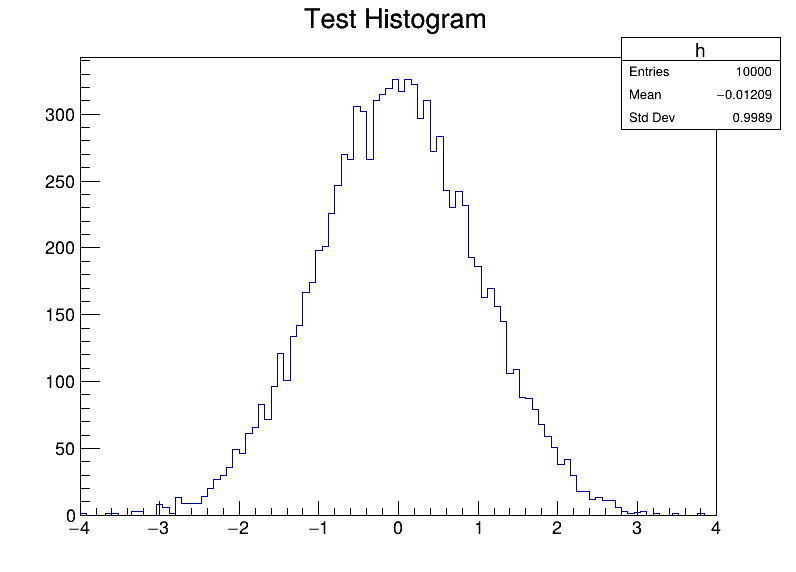

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: pdf file histogram.pdf has been created


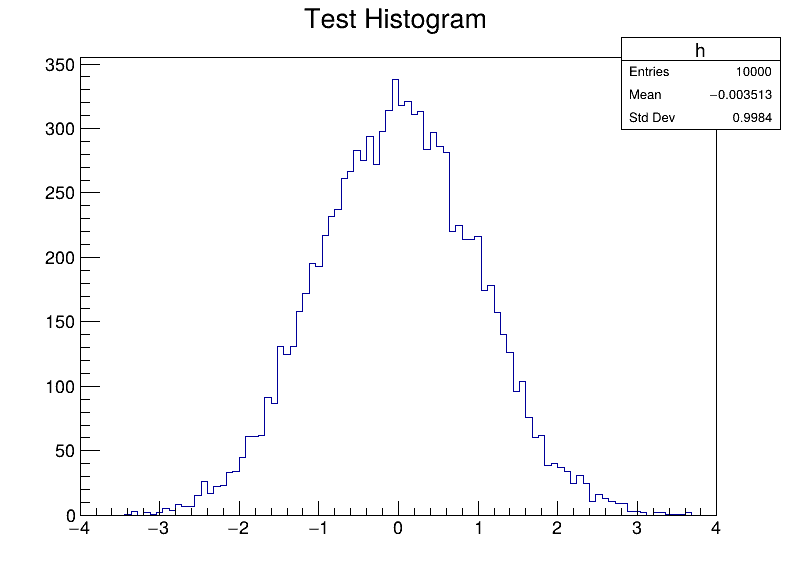

In [7]:

# 创建一个直方图
h = ROOT.TH1F("h", "Test Histogram", 100, -4, 4)
h.FillRandom("gaus", 10000)

# 创建画布
canvas = ROOT.TCanvas("canvas", "Canvas", 800, 600)

# 绘制直方图
h.Draw()

# 保存图片
canvas.SaveAs("histogram.pdf")
canvas.SaveAs("histogram.png")

# 在Jupyter Notebook中显示图片
from IPython.display import Image
Image(filename="histogram.png")


In [3]:
import ROOT
from tqdm import tqdm
import numpy as np
import ctypes
import copy

# 定义读取路径和保存路径
path = '/Users/fengy/ANNIESofts/Analysis/ProjectionComplete/data/'
SavePath = '/Users/fengy/ANNIESofts/Analysis/ProjectionComplete/plots/'
file_name = path + 'LAPPDBeamCluster_3795.root'

# 打开ROOT文件，使用UPDATE模式以便可以修改Tree
file = ROOT.TFile(file_name, "UPDATE")
tree = file.Get("Event")

# 定义 std::vector 来存储浮点数
SimLAPPDHitMuIndex = ROOT.std.vector('double')()
SimLAPPDHitID = ROOT.std.vector('double')()
SimLAPPDHitPE = ROOT.std.vector('double')()
SimLAPPDHitTime = ROOT.std.vector('double')()



b_simIndex = tree.Branch("SimMuIndex",SimLAPPDHitMuIndex)
b_simID = tree.Branch("SimLAPPDHitID",SimLAPPDHitID)
b_simPE = tree.Branch("SimLAPPDHitPE",SimLAPPDHitPE)
b_simTime = tree.Branch("SimLAPPDHitTime",SimLAPPDHitTime)


# 定义过滤事件的条件
cut_beamOK = True
cut_clusterExist = True
cut_clusterCB = True
cut_clusterCB_value = 0.2
cut_clusterMaxPE = True
cut_clusterMaxPE_value = 500
cut_noVeto = False
cut_MRDPMTCoinc = False
cut_ChrenkovCover = False
cut_ChrenkovCover_nPMT = 4
cut_ChrenkovCover_PMT_PE = 5
cut_LAPPDMultip = False
cut_LAPPDHitAmp = 5
cut_LAPPDHitNum = 7

# 总事件计数器
totalNumOfEvent = 0
passCutNumOfEvent = 0

# 遍历Tree的每个事件
for i in tqdm(range(tree.GetEntries())):
    tree.GetEntry(i)
    totalNumOfEvent += 1
    


    SimLAPPDHitMuIndex.clear()
    SimLAPPDHitID.clear()
    SimLAPPDHitPE.clear()
    SimLAPPDHitTime.clear()

    processThisEntry = True

    
    if cut_clusterExist and tree.numberOfClusters < 1:
        processThisEntry = False

    if cut_clusterExist:
        if tree.numberOfClusters < 1:
            processThisEntry = False

        ExistClusterInPrompt = False
        for i in tree.clusterTime:
            if i < 2000:
                ExistClusterInPrompt = True
        if not ExistClusterInPrompt:
            processThisEntry = False

    Brit_est_index = -1
    Brit_PE = -1
    for i in range(len(tree.clusterPE)):
        if tree.clusterPE[i]>Brit_PE:
            Brit_PE = tree.clusterPE[i]
            Brit_est_index = i

    if Brit_est_index == -1:
        processThisEntry = False


    if(not processThisEntry):

        b_simTime.Fill()
        b_simID.Fill()
        b_simIndex.Fill()
        b_simPE.Fill()
        
    else:
        maxIndex = int(np.argmax(tree.clusterMaxPE))
        passCutNumOfEvent += 1
        
        #print(i, tree.clusterPE[maxIndex])

        for j in range(tree.numberOfClusters):
            SimLAPPDHitMuIndex.push_back(j)
            SimLAPPDHitID.push_back(j)
            if(len(tree.LAPPD_PeakAmp)>0):
                SimLAPPDHitPE.push_back(max(tree.LAPPD_PeakAmp))
                SimLAPPDHitTime.push_back(sum(tree.LAPPD_PeakTime)/len(tree.LAPPD_PeakTime))
            


        # 填充新branch
        b_simTime.Fill()
        b_simID.Fill()
        b_simIndex.Fill()
        b_simPE.Fill()

        print(tree.SimLAPPDHitPE)



# 将更新后的TTree写回文件
file.cd()  # 确保在正确的目录
tree.Write("", ROOT.TObject.kOverwrite)  # 保存TTree
file.Close()  # 关闭文件

# 打印统计信息
print(f"Total number of loaded events: {totalNumOfEvent}")
print(f"Total number of events passed cuts: {passCutNumOfEvent}")



100%|████████████████████████████████████| 1719/1719 [00:00<00:00, 10325.00it/s]


{ 28.795000 }
{ 66.490000, 66.490000 }
{ 42.780000, 42.780000, 42.780000, 42.780000, 42.780000 }
{ 33.540000, 33.540000, 33.540000, 33.540000 }
{ 66.340000, 66.340000, 66.340000, 66.340000, 66.340000, 66.340000, 66.340000 }
{ 27.400000 }
{ 39.400000 }
{ 72.260000 }
{ 60.330000 }
{ 36.735000 }
{ 58.195000, 58.195000, 58.195000, 58.195000, 58.195000, 58.195000, 58.195000, 58.195000, 58.195000, 58.195000 }
{ 27.960000 }
{ 52.380000, 52.380000, 52.380000, 52.380000, 52.380000, 52.380000 }
{ 54.215000, 54.215000, 54.215000 }
{ 70.315000, 70.315000 }
{ 30.025000, 30.025000, 30.025000, 30.025000, 30.025000, 30.025000 }
{ 34.800000, 34.800000 }
{ 48.770000, 48.770000, 48.770000, 48.770000, 48.770000, 48.770000, 48.770000 }
{ 35.120000, 35.120000 }
{ 46.105000, 46.105000, 46.105000, 46.105000, 46.105000, 46.105000, 46.105000 }
{ 85.860000, 85.860000, 85.860000, 85.860000, 85.860000 }
{ 52.040000 }
{ 56.010000 }
{ 39.160000, 39.160000, 39.160000, 39.160000, 39.160000, 39.160000, 39.160000, 39.16

Total number of entries: 666
Run 3825  part file  39


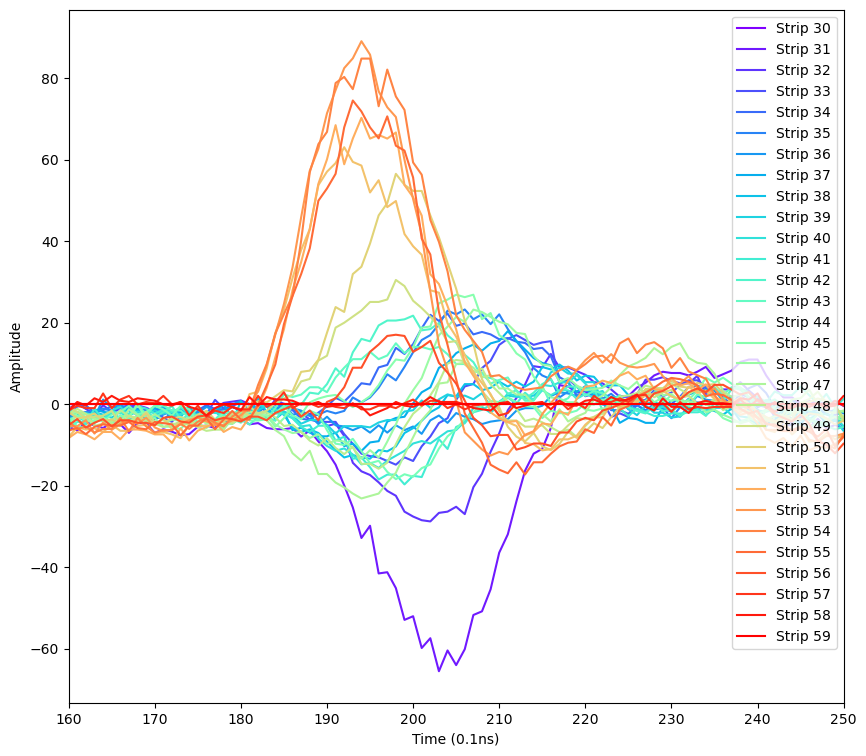

In [207]:
import ROOT
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm


file = '/Users/fengy/ANNIESofts/Analysis/ForwardFolding/testFile/ANNIETree_Ped2022_all.root'


file = ROOT.TFile(file, "READ")
tree = file.Get("Event")


print("Total number of entries:", tree.GetEntries())
colors = cm.rainbow(np.linspace(0, 1, 30))

printEntry = 120
tree.GetEntry(printEntry)
print("Run",tree.runNumber," part file ", tree.partFileNumber)
plt.figure(figsize=(10, 9))
waveform = []
for i in range (30,60):
    waveform.append(np.array(tree.LAPPDWaveform[i]))

    plt.plot(np.array(tree.LAPPDWaveform[i]),label = "Strip "+str(i), color=colors[i-30])

plt.xlim(160,250)
plt.legend(loc = "upper right")
plt.ylabel("Amplitude")
plt.xlabel("Time (0.1ns)")

file.Close()  

Total number of entries: 871
Run 4223  part file  370


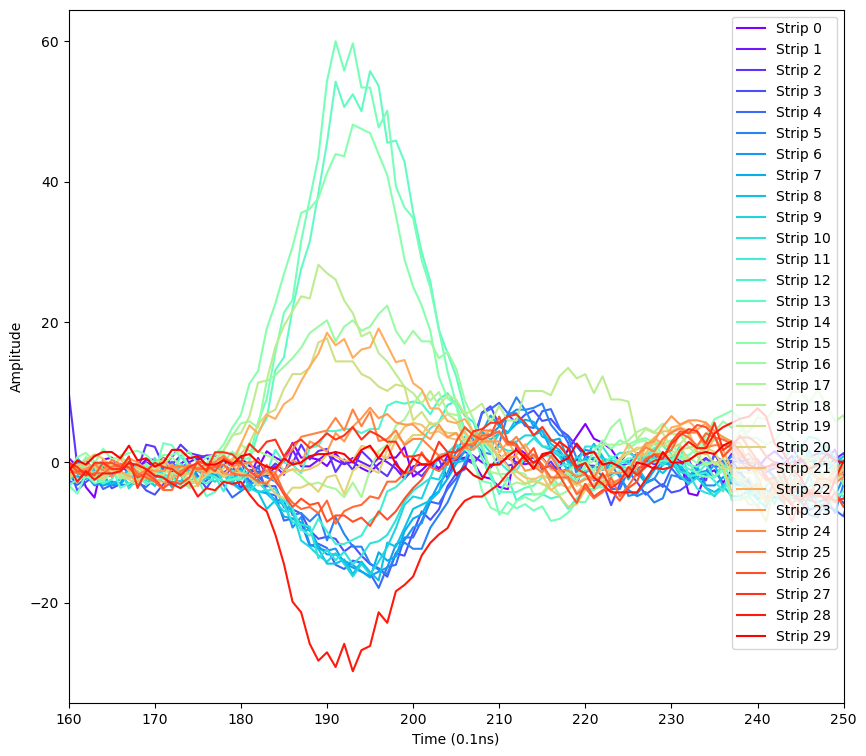

In [195]:
import ROOT
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm


file = '/Users/fengy/ANNIESofts/Analysis/ForwardFolding/testFile/ANNIETree_Ped2022_all.root'
file = '/Users/fengy/ANNIESofts/Analysis/ForwardFolding/testFile/ANNIETree_SANDI_all.root'

printEntry = 150

file = ROOT.TFile(file, "READ")
tree = file.Get("Event")

print("Total number of entries:", tree.GetEntries())
colors = cm.rainbow(np.linspace(0, 1, 30))


tree.GetEntry(printEntry)
print("Run",tree.runNumber," part file ", tree.partFileNumber)
plt.figure(figsize=(10, 9))
waveform = []
for i in range (0,30):
    waveform.append(np.array(tree.LAPPDWaveform[i]))

    plt.plot(np.array(tree.LAPPDWaveform[i]),label = "Strip "+str(i), color=colors[i])

plt.xlim(160,250)
plt.legend(loc = "upper right")
plt.ylabel("Amplitude")
plt.xlabel("Time (0.1ns)")

file.Close()  

In [238]:
from scipy.spatial import KDTree


def LAPPD_Grid_position(LAPPD_Center_Position, LAPPD_direction):
    L_grid_y = 0.01
    L_grid_x = 0.00691
    steps_y = 14
    steps_x = 14

    n = LAPPD_direction / np.linalg.norm(LAPPD_direction)
    reference_vec = np.array([0, 1, 0])
    sx = np.cross(n, reference_vec)
    sx /= np.linalg.norm(sx)

    sy = np.cross(n, sx)
    sy /= np.linalg.norm(sy)

    steps_y_total = 2 * steps_y
    y_positions = [sy * L_grid_y * (steps_y - 0.5) - sy * L_grid_y * i for i in range(steps_y_total)]
    positions = np.zeros((steps_y_total, 2 * steps_x, 3))
    
    for i, y_vec in enumerate(y_positions):
        x_start = -sx * L_grid_x * (steps_x - 0.5)
        for j in range(2 * steps_x):
            x_offset = x_start + sx * L_grid_x * j
            pos = LAPPD_Center_Position + y_vec + x_offset
            positions[i, j, :] = pos

    return positions


LAPPD_Centers = [[0,-0.2255,2.951]] # center of LAPPD 40
LAPPD_Directions = [[0,0,-1], [1,0,-1], [-1,0,-1]]
LAPPD_stripWidth = 0.462
LAPPD_stripSpace = 0.229
LAPPD_gridSize = LAPPD_stripWidth + LAPPD_stripSpace
LAPPD_grids = []
for i in range (len(LAPPD_Centers)):
    LAPPD_grids.append(LAPPD_Grid_position(np.array(LAPPD_Centers[i]), np.array(LAPPD_Directions[i])))

print(LAPPD_grids[0])

[[[-0.093285 -0.3605    2.951   ]
  [-0.086375 -0.3605    2.951   ]
  [-0.079465 -0.3605    2.951   ]
  ...
  [ 0.079465 -0.3605    2.951   ]
  [ 0.086375 -0.3605    2.951   ]
  [ 0.093285 -0.3605    2.951   ]]

 [[-0.093285 -0.3505    2.951   ]
  [-0.086375 -0.3505    2.951   ]
  [-0.079465 -0.3505    2.951   ]
  ...
  [ 0.079465 -0.3505    2.951   ]
  [ 0.086375 -0.3505    2.951   ]
  [ 0.093285 -0.3505    2.951   ]]

 [[-0.093285 -0.3405    2.951   ]
  [-0.086375 -0.3405    2.951   ]
  [-0.079465 -0.3405    2.951   ]
  ...
  [ 0.079465 -0.3405    2.951   ]
  [ 0.086375 -0.3405    2.951   ]
  [ 0.093285 -0.3405    2.951   ]]

 ...

 [[-0.093285 -0.1105    2.951   ]
  [-0.086375 -0.1105    2.951   ]
  [-0.079465 -0.1105    2.951   ]
  ...
  [ 0.079465 -0.1105    2.951   ]
  [ 0.086375 -0.1105    2.951   ]
  [ 0.093285 -0.1105    2.951   ]]

 [[-0.093285 -0.1005    2.951   ]
  [-0.086375 -0.1005    2.951   ]
  [-0.079465 -0.1005    2.951   ]
  ...
  [ 0.079465 -0.1005    2.951   ]
  [ 

In [236]:
print(LAPPD_grids[0].reshape(-1, 3))

[[-0.093285 -0.3605    2.951   ]
 [-0.086375 -0.3605    2.951   ]
 [-0.079465 -0.3605    2.951   ]
 ...
 [ 0.079465 -0.0905    2.951   ]
 [ 0.086375 -0.0905    2.951   ]
 [ 0.093285 -0.0905    2.951   ]]


In [286]:
t = KDTree(LAPPD_grids[0].reshape(-1, 3))
distance, idx =t.query((0.07,-0.29,2.951), k=1)
print(distance, idx)
x_index, y_index = np.unravel_index(idx, LAPPD_grids[0].shape[:2])
print(x_index, y_index)
print(LAPPD_grids[0][x_index][y_index])


0.0026034640385455697 220
7 24
[ 0.072555 -0.2905    2.951   ]


In [272]:
for i in range (10):
    print(LAPPD_grids[0][i][0])
#loop first index gives different y
#loop second index gives different x

[-0.093285 -0.3605    2.951   ]
[-0.093285 -0.3505    2.951   ]
[-0.093285 -0.3405    2.951   ]
[-0.093285 -0.3305    2.951   ]
[-0.093285 -0.3205    2.951   ]
[-0.093285 -0.3105    2.951   ]
[-0.093285 -0.3005    2.951   ]
[-0.093285 -0.2905    2.951   ]
[-0.093285 -0.2805    2.951   ]
[-0.093285 -0.2705    2.951   ]


In [266]:
LAPPD_waveforms = np.zeros((28, 2, 256)) 
print(LAPPD_waveforms.shape)

(28, 2, 256)


In [270]:
hit = (2,10,10,0.1,0.4)
a,b,c,d,e = hit
print(a,b,c,d,e)

2 10 10 0.1 0.4


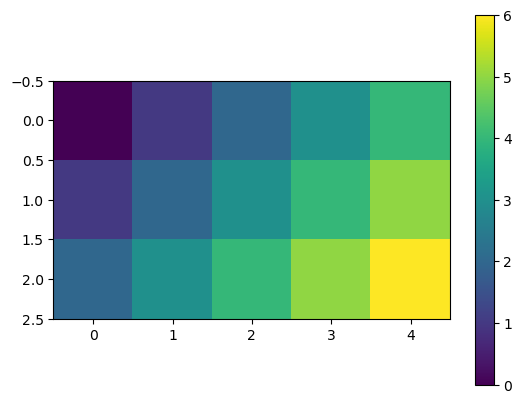

In [280]:
test = [[0,1,2,3,4],[1,2,3,4,5],[2,3,4,5,6]]


im = plt.imshow(test)
plt.colorbar(im)

In [294]:
a = [1,2,3]
b = [2,3,4]
c = [3,4,5]
x = [a,b,c]
y = [c,b,a]

z = [x,x,y]

print(z)
print(np.flip(z,axis = 0))

[[[1, 2, 3], [2, 3, 4], [3, 4, 5]], [[1, 2, 3], [2, 3, 4], [3, 4, 5]], [[3, 4, 5], [2, 3, 4], [1, 2, 3]]]
[[[3 4 5]
  [2 3 4]
  [1 2 3]]

 [[1 2 3]
  [2 3 4]
  [3 4 5]]

 [[1 2 3]
  [2 3 4]
  [3 4 5]]]


In [307]:
a = [1,2,3,4,5,6,7,8,9,10,1,2,3,4,5,6,7,8,9,0]
b = np.zeros(6)
for i in range(6):
    b[i] = a[(i+2)%6]
print(a[2:8])

[3, 4, 5, 6, 7, 8]


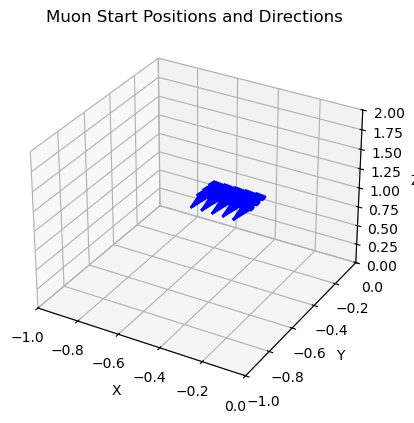

In [321]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 初始的Muon位置和方向
muon_start_position = [-0.374149027601086, -0.5679029804241634, 1.2]
mu_direction = np.array([0.29269516, 0.11321445, 0.94947987])

# 步数和步长设定
x_step = 2
x_step_size = 0.05
y_step = 1
y_step_size = 0.05
theta_step = 2
theta_step_size = np.radians(3)  # 转换成弧度
phi_step = 1
phi_step_size = np.radians(3)  # 转换成弧度
arrow_length = 0.2  # 箭头长度

# 定义旋转矩阵
def rotate_vector(vector, theta, phi):
    """旋转向量 vector, theta 是绕y轴旋转的角度，phi 是绕x轴旋转的角度"""
    # 绕y轴旋转 (theta)
    rot_y = np.array([[np.cos(theta), 0, np.sin(theta)],
                      [0, 1, 0],
                      [-np.sin(theta), 0, np.cos(theta)]])
    # 绕x轴旋转 (phi)
    rot_x = np.array([[1, 0, 0],
                      [0, np.cos(phi), -np.sin(phi)],
                      [0, np.sin(phi), np.cos(phi)]])
    
    # 先绕y轴旋转，再绕x轴旋转
    rotated_vector = rot_x @ (rot_y @ vector)
    return rotated_vector

# 创建3D图
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 遍历x和y坐标，调整Muon起始位置
for x_offset in range(-x_step, x_step + 1):
    for y_offset in range(-y_step, y_step + 1):
        # 计算新的x, y坐标
        x_at_z = muon_start_position[0] + x_offset * x_step_size
        y_at_z = muon_start_position[1] + y_offset * y_step_size
        z_at_z = muon_start_position[2]
        new_start_position = [x_at_z, y_at_z, z_at_z]

        # 遍历theta和phi，调整Muon方向
        for theta_offset in range(-theta_step, theta_step + 1):
            for phi_offset in range(-phi_step, phi_step + 1):
                # 计算新的theta和phi
                theta = theta_offset * theta_step_size
                phi = phi_offset * phi_step_size
                
                # 旋转初始Muon方向
                new_mu_direction = rotate_vector(mu_direction, theta, phi)
                new_mu_direction = new_mu_direction / np.linalg.norm(new_mu_direction)  # 归一化

                # 绘制箭头，箭头起点为start position，方向为muon direction
                ax.quiver(new_start_position[0], new_start_position[1], new_start_position[2], 
                          new_mu_direction[0], new_mu_direction[1], new_mu_direction[2], 
                          length=arrow_length, color='b', arrow_length_ratio=0.2)

# 设置X, Y, Z轴的范围为[-2, 2]
ax.set_xlim([-1, 0])
ax.set_ylim([-1, 0])
ax.set_zlim([0, 2])

# 设置图像标签
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Muon Start Positions and Directions')

# 显示图像
plt.show()


In [331]:
import json


result = [[-0.8414248282064837, -0.9639699145161424, 1.2, 0.4515366263310098, 0.3708878818251112, 0.8115151595607395, 72737.60165811123, 350.5467241348069], [-0.8414248282064837, -0.9639699145161424, 1.2, 0.4515366263310098, 0.28402968665454503, 0.8458379349382074, 31789.159851952954, 166.36893564332402], [-0.8414248282064837, -0.9639699145161424, 1.2, 0.4943469086628693, 0.28532598716547497, 0.8211030477007817, 28383.317863498807, 139.5225694612589], [-0.8414248282064837, -0.9639699145161424, 1.2, 0.5358022204797162, 0.36817979773508536, 0.7598418368770947, 25981.972967208596, 123.98728116310849], [-0.8414248282064837, -0.9639699145161424, 1.2, 0.5358022204797162, 0.3279081709918637, 0.7780695418314333, 25694.9130318884, 122.80396628259965], [-0.8414248282064837, -0.9639699145161424, 1.2, 0.5358022204797162, 0.28673777074457085, 0.7941646122545626, 23313.05121460885, 109.65221226494596], [-0.7914248282064836, -0.9639699145161424, 1.2, 0.5358022204797162, 0.36817979773508536, 0.7598418368770947, 23272.4968495992, 108.58637914462737], [-0.7914248282064836, -0.9639699145161424, 1.2, 0.5358022204797162, 0.3279081709918637, 0.7780695418314333, 23119.49440075252, 107.55412897379094], [-0.7914248282064836, -0.9639699145161424, 1.2, 0.5358022204797162, 0.28673777074457085, 0.7941646122545626, 21159.238388943355, 96.66316894398834], [-0.7414248282064836, -0.9639699145161424, 1.2, 0.5358022204797162, 0.36817979773508536, 0.7598418368770947, 21064.98822374518, 95.62998435159989], [-0.7414248282064836, -0.9639699145161424, 1.2, 0.5358022204797162, 0.3279081709918637, 0.7780695418314333, 20980.900903071153, 95.35276051230758], [-0.7414248282064836, -0.9639699145161424, 1.2, 0.5358022204797162, 0.28673777074457085, 0.7941646122545626, 19427.351385083824, 87.31720826344738]]



# 保存为json文件
output_file = '/Users/fengy/Downloads/result.txt'
with open(output_file, 'w') as file:
    json.dump(result, file)

print(f"Data has been saved to {output_file}")

    

Data has been saved to /Users/fengy/Downloads/result.txt


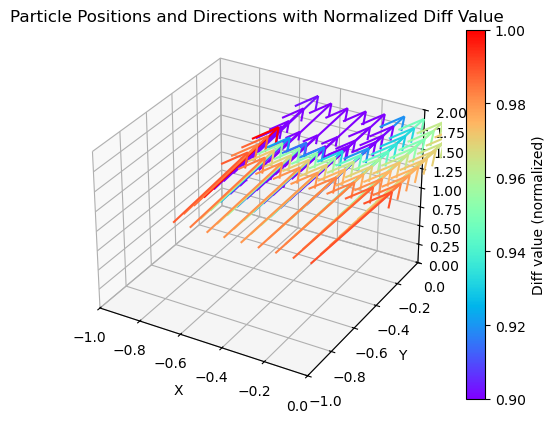

In [393]:
import json
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

# 读取数据
i#nput_file = '/Users/fengy/ANNIESofts/Analysis/ProjectionComplete/plots/Event36output_1111_3degree.txt'
input_file = '/Users/fengy/ANNIESofts/Analysis/ProjectionComplete/plots/Event36output.txt'
with open(input_file, 'r') as file:
    result = json.load(file)

# 提取所有的diff value，用于归一化
diff_values = [elem[6] for elem in result]  # 第7个元素是diff value
diff_values = np.array(diff_values)

# 归一化diff value
norm_diff_values = (diff_values - np.min(diff_values)) / (np.max(diff_values) - np.min(diff_values))
#print(norm_diff_values)

# 创建3D图
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colorMin = 0.9

# 遍历每个粒子的数据
for i, elem in enumerate(result):
    # 读取粒子的x, y, z位置 (第0, 1, 2个元素)
    x, y, z = elem[0], elem[1], elem[2]
    
    # 读取粒子的x, y, z方向 (第3, 4, 5个元素)
    dir_x, dir_y, dir_z = elem[3], elem[4], elem[5]
    
    # 获取归一化的diff value（第6个元素）并计算箭头长度
    normalized_value = norm_diff_values[i]
    arrow_length = 1 - normalized_value 

    # smaller normalized_value is better solution
    # arrow_length closer to 1, better


    thisColorValue = 0
    if(arrow_length>colorMin):
        thisColorValue = (arrow_length - colorMin)/(1-colorMin)
    
    # 计算颜色，使用rainbow colormap
    color = cm.rainbow(thisColorValue)  # 颜色根据归一化后的值映射
    #print(arrow_length, thisColorValue)
    # 绘制箭头，起点是x, y, z，方向是dir_x, dir_y, dir_z
    ax.quiver(x, y, z, dir_x, dir_y, dir_z, length=arrow_length, color=color, arrow_length_ratio=0.2)

# 设置颜色条
norm = plt.Normalize(vmin=colorMin, vmax=1)
sm = plt.cm.ScalarMappable(cmap=cm.rainbow, norm=norm)
sm.set_array([])

# 设置颜色条
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Diff value (normalized)')

# 设置图像标签
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Particle Positions and Directions with Normalized Diff Value')

ax.set_xlim([-1, 0])
ax.set_ylim([-1, 0])
ax.set_zlim([0, 2])

# 显示图像
plt.show()


In [403]:
w1 = [9,10,3,4,5,6]
w2 = np.array([3,4,5,6,7,8])

s = [i for i in w1-w2 if i > 0]

print(w1-w2)
print(s)

[ 6  6 -2 -2 -2 -2]
[6, 6]
